## Import features

In [1]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import time
import xgboost as xgb

# Ensure working directory path is correct
import pandas as pd

while os.path.split(os.getcwd())[-1] != "Options-Project":
    os.chdir(os.path.dirname(os.getcwd()))

### User Defined Variables

In [2]:
ticker = "AAPL"
model_params_path = "data/model_params/"
adj_close_path = "data/adj_close/"
dividends_path = "data/dividends/"

### Load Model Parameters

In [5]:
start_time = time.time()

model_params = dict()

for param_type in next(os.walk(model_params_path))[1]:

    param_path = os.path.join(model_params_path, param_type, ticker)
    param_list = []

    # Sanity check
    assert os.path.isdir(param_path), f"Can't find model parameters for {ticker}!"

    for file_year in os.listdir(param_path):
        if file_year.split("_")[-1] == "param.csv":
            df = pd.read_csv(os.path.join(param_path, file_year))

            # Convert columns to correct format
            df["date"] = pd.to_datetime(df["date"]).dt.date

            if "interval" in df.columns:
                df["interval"] = df["interval"].astype(str)

            param_list.append(df)

    # Concat & add to model params
    if param_list:
        df = pd.concat(param_list, ignore_index=True)
        df.sort_values(by=["date", "tag"], inplace=True)
        model_params[param_type] = df

print(f"Load model parameters - {round(time.time() - start_time, 2)} seconds")

Load model parameters - 0.22 seconds


### Format Model Parameters

In [6]:
# Pivot & combine model parameters to 1 row per day

param_df = pd.DataFrame(columns=["date"])

for param_type in model_params.keys():

    if param_type == "custom":
        pivot_cols = ["tag"]
    else:
        pivot_cols = ["tag", "interval"]

    df = model_params[param_type].pivot(index="date", columns=pivot_cols)

    # Flatten column levels
    df.columns = ["-".join(col) for col in df.columns.values]

    # # Update param dict
    # model_params[param_type] = df.reset_index()

    # Add to all params
    param_df = param_df.merge(df, on="date", how="outer", validate="1:1")


In [7]:
print(f"Total days: {param_df.shape[0]}")
print(f"Days without missing data: {param_df.dropna().shape[0]}")

Total days: 4273
Days without missing data: 3740


### Load Prediction Target

In [28]:
date_close_df = pd.read_csv(os.path.join(adj_close_path, ticker, (ticker + ".csv")))
date_close_df["date"] = pd.to_datetime(date_close_df["date"]).dt.date

dividends_df = pd.read_csv(os.path.join(dividends_path, ticker, (ticker + "_ts.csv")))
dividends_df["date"] = pd.to_datetime(dividends_df["date"]).dt.date

date_close_df = date_close_df[["date", "close"]].merge(right=dividends_df,
                                                       how="inner", on="date")

date_close_df["adj_close"] = (date_close_df["close"] - date_close_df["dividend"]).round(6)
target_df = date_close_df[["date", "adj_close"]].copy()

### Standardize Prediction Target

Detrend by taking `n` day difference between end-of-day (EOD) closing prices

Normalize taking residual and dividing by EOD price

Methodology in [EDA2](https://github.com/jacktan1/Options-Project/blob/master/src/EDA_1.ipynb)

In [29]:
n = 20

target_df[f"delta_{n}_norm"] = (target_df["adj_close"].shift(periods=-n) - target_df["adj_close"]) / target_df[
    "adj_close"]

target_df["naive_predictor"] = target_df[f"delta_{n}_norm"].shift(periods=1)

target_df = target_df[["date", f"delta_{n}_norm", "naive_predictor"]].dropna()

### XGBoost

Drop rows with missing values because all features are continuous. One-hot encoding to create new features don't make much sense

In [30]:
combined_df = param_df.merge(target_df, on="date", how="inner", validate="1:1").dropna()

X_params = combined_df.drop(columns=["date", f"delta_{n}_norm", "naive_predictor"])
X_naive = combined_df["naive_predictor"]
y = combined_df[f"delta_{n}_norm"]

X_train, X_test, y_train, y_test = train_test_split(X_params, y,
                                                    train_size=0.8,
                                                    shuffle=False)

X_train_naive, X_test_naive, y_train_naive, y_test_naive = train_test_split(X_naive, y,
                                                                            train_size=0.8,
                                                                            shuffle=False)

### Train

In [31]:
dummy_model = xgb.XGBRegressor()

dummy_model.fit(X_train_naive, y_train_naive,
                early_stopping_rounds=10,
                eval_metric="rmse",
                eval_set=[(X_test_naive, y_test_naive)])

[0]	validation_0-rmse:0.32647
[1]	validation_0-rmse:0.23009
[2]	validation_0-rmse:0.16268
[3]	validation_0-rmse:0.11600
[4]	validation_0-rmse:0.08419
[5]	validation_0-rmse:0.06319
[6]	validation_0-rmse:0.04976
[7]	validation_0-rmse:0.04166
[8]	validation_0-rmse:0.03705
[9]	validation_0-rmse:0.03457
[10]	validation_0-rmse:0.03343
[11]	validation_0-rmse:0.03282
[12]	validation_0-rmse:0.03260
[13]	validation_0-rmse:0.03251
[14]	validation_0-rmse:0.03261
[15]	validation_0-rmse:0.03261
[16]	validation_0-rmse:0.03272
[17]	validation_0-rmse:0.03271
[18]	validation_0-rmse:0.03266
[19]	validation_0-rmse:0.03267
[20]	validation_0-rmse:0.03265
[21]	validation_0-rmse:0.03263
[22]	validation_0-rmse:0.03266


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=24,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [32]:
my_model = xgb.XGBRegressor()

my_model.fit(X_train, y_train,
             early_stopping_rounds=10,
             eval_metric="rmse",
             eval_set=[(X_test, y_test)])

[0]	validation_0-rmse:0.32477
[1]	validation_0-rmse:0.22947
[2]	validation_0-rmse:0.16401
[3]	validation_0-rmse:0.12431
[4]	validation_0-rmse:0.10280
[5]	validation_0-rmse:0.09422
[6]	validation_0-rmse:0.09095
[7]	validation_0-rmse:0.09012
[8]	validation_0-rmse:0.09144
[9]	validation_0-rmse:0.09258
[10]	validation_0-rmse:0.09418
[11]	validation_0-rmse:0.09467
[12]	validation_0-rmse:0.09555
[13]	validation_0-rmse:0.09559
[14]	validation_0-rmse:0.09642
[15]	validation_0-rmse:0.09674
[16]	validation_0-rmse:0.09784
[17]	validation_0-rmse:0.09765


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=24,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [33]:
import plotly.graph_objects as go

my_pred = my_model.predict(X_test)

PRED_DF = combined_df[["date", f"delta_{n}_norm"]].merge(y_test.to_frame(), on=f"delta_{n}_norm", how="right").rename(
    columns={f"delta_{n}_norm": "actual"})

PRED_DF["pred"] = my_pred

fig = go.Figure(data=go.Scatter(x=PRED_DF["pred"],
                                y=PRED_DF["actual"],
                                text=PRED_DF["date"],
                                mode='markers', showlegend=False,
                                marker=dict(size=5, color="red", opacity=0.5)))

fig.show()

In [34]:
from scipy.stats import kendalltau

[tau, pval] = kendalltau(PRED_DF["pred"], PRED_DF["actual"])

print([tau, pval])

[0.01791417412501255, 0.46377324213368054]


## Naive Model

In [35]:
my_pred = dummy_model.predict(X_test_naive)

PRED_DF = combined_df[["date", f"delta_{n}_norm"]].merge(y_test_naive.to_frame(), on=f"delta_{n}_norm", how="right").rename(
    columns={f"delta_{n}_norm": "actual"})

PRED_DF["pred"] = my_pred

fig = go.Figure(data=go.Scatter(x=PRED_DF["pred"],
                                y=PRED_DF["actual"],
                                text=PRED_DF["date"],
                                mode='markers', showlegend=False,
                                marker=dict(size=5, color="red", opacity=0.5)))

fig.show()

In [38]:
from scipy.stats import kendalltau

[tau, pval] = kendalltau(PRED_DF["pred"], PRED_DF["actual"])

print([tau, pval])

[0.7746415062225351, 7.53950771124955e-217]


In [37]:
fig = go.Figure(data=go.Scatter(x=X_test_naive,
                                y=y_test_naive,
                                mode='markers', showlegend=False))

fig.show()

In [39]:
from scipy.stats import kendalltau

[tau, pval] = kendalltau(X_test_naive, y_test_naive)

print([tau, pval])

[0.7706118592015121, 2.453177634145574e-218]


### Feature Importance

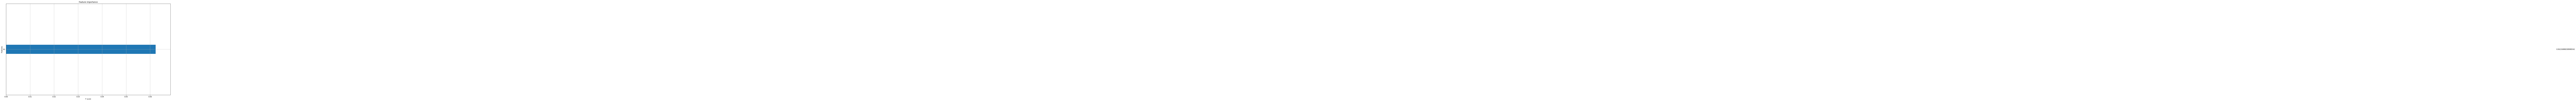

In [21]:
param_importance = xgb.plot_importance(dummy_model, importance_type="gain").get_figure()

param_importance.set_size_inches(18.5, 10.5)
param_importance.savefig("img/param_importance.svg")

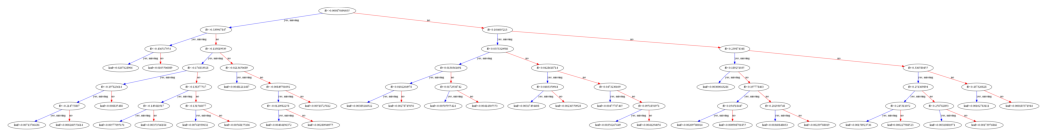

In [30]:
tree_plot = xgb.plot_tree(dummy_model, num_trees=10).get_figure()

tree_plot.set_size_inches(18.5, 10.5)
tree_plot.savefig("img/tree_plot.svg", dpi=1000)